<a href="https://colab.research.google.com/github/Hackman-git/Mechanisms_of_action/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import plotly.express as px

In [60]:
train_x = pd.read_csv('/content/drive/My Drive/MOA/Data/train_features.csv')
train_y = pd.read_csv("/content/drive/My Drive/MOA/Data/train_targets_scored.csv")
test = pd.read_csv("/content/drive/My Drive/MOA/Data/test_features.csv")
submit = pd.read_csv("/content/drive/My Drive/MOA/Data/sample_submission.csv")

In [3]:
train_x.shape

(23814, 876)

875 features in the dataset

In [4]:
train_y.shape

(23814, 207)

206 targets, multioutput classification

In [ ]:
submit.shape

(3982, 207)

In [5]:
train_x.head(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


In [6]:
train_y.head(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
submit.head(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


We have 772 gene expression features

In [ ]:
cols = train_x.columns
gene_cols = [col for col in cols if col.startswith('g-')]
gene_cols_count = len(gene_cols)

gene_cols_count

772

and 100 cell viability features

In [ ]:
cell_cols = [col for col in cols if col.startswith("c-")]
cell_cols_count = len(cell_cols)

cell_cols_count

100

Distribution of the more expressive features

In [26]:
# distribution of testing time
d = train_x.groupby('cp_time')['sig_id'].count().reset_index()
d= d.rename(columns={'sig_id':'count'})
fig = px.bar(d, x='cp_time', y='count')
fig.update_layout(width=800, height=300)
fig.show()

In [28]:
# distribution of dosage
d = train_x.groupby('cp_dose')['sig_id'].count().reset_index()
d= d.rename(columns={'sig_id':'count'})
fig = px.bar(d, x='cp_dose', y='count')
fig.update_layout(width=800, height=300)
fig.show()

In [30]:
# distribution on treatment type
d = train_x.groupby('cp_type')['sig_id'].count().reset_index().rename(columns={'sig_id':'count'})
fig = px.bar(d, x='cp_type', y='count')
fig.update_layout(width=800, height=300)
fig.show()

In [31]:
test.cp_type.value_counts()

trt_cp         3624
ctl_vehicle     358
Name: cp_type, dtype: int64

What's the distibution of the count of cell activations for the drug samples

In [43]:
temp = train_y.copy()
temp['total'] = temp.sum(axis=1, numeric_only=True)
d = temp.groupby('total')['sig_id'].count().reset_index().rename(columns={'sig_id':'count', 'total':'num_of_cells_activated'})
fig = px.bar(d, x='num_of_cells_activated', y='count')
fig.update_layout(width=800, height=400)
fig.show()


we have 9367 observations with all zeros as targets

What classes are most prominent

In [66]:
d = dict()
for i in train_y.columns[1:]:
    d[i] = train_y[i].sum()
temp = pd.Series(d)
temp = pd.DataFrame(temp).reset_index()
temp.columns = ['target', 'count']
temp = temp.sort_values('count', ascending=False)
fig = px.bar(temp[:20], x='count', y='target', orientation='h')
fig.update_layout(width=800, height=500)
fig.show()

We see that Inhibitors seem to be the most prominent cell types in the train targets

In [71]:
med = temp['count'].median()
med

38.5

A median occurence of ~39 means most of the targets rarely occur. The data is severly imbalanced

At this point it is important to note that there are certain groups of targets

In [97]:
targets = train_y.columns[1:]

In [86]:
kind = []
for i in targets:
    if len(i.split('_')) > 1:
        kind.append(i.split('_')[-1])
kind = list(set(kind))
print(kind)

['activator', 'stimulant', 'antifolate', 'scavenger', 'inhibitor', 'donor', 'sensitizer', 'medium', 'agonist', 'b', 'antagonist', 'secretagogue', 'local', 'agent', 'blocker']


In [96]:
d = dict()
for i in kind:
    d[i] = len([j for j in targets if j.endswith('_'+i)])

temp = pd.DataFrame(pd.Series(d)).reset_index()
temp.columns =['target', 'count']
temp = temp[temp['count'] > 1].sort_values('count', ascending=False)

fig = px.bar(temp, x='target', y='count')
fig.update_layout(width=800, height=300)
fig.show()

We have most targets as "Inhibitors", "agonists", and "antagonists"

In [98]:
inhibitors = [i for i in targets if i.endswith('_inhibitor')]
agonists = [i for i in targets if i.endswith('_agonist')]
antagonists = [i for i in targets if i.endswith('_antagonist')]
activators = [i for i in targets if i.endswith('_activator')]

Let's study the anonymized features (gene expression and cell viability)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


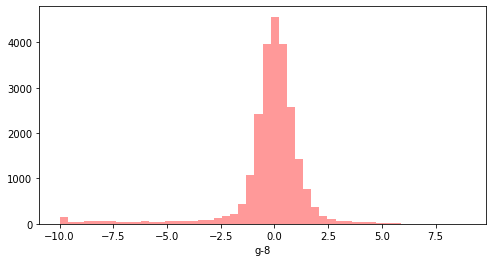

In [ ]:
# distribution of a g-8
plt.figure(figsize=(8,4))
sns.distplot(train_x['g-8'], kde=False, color="red")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


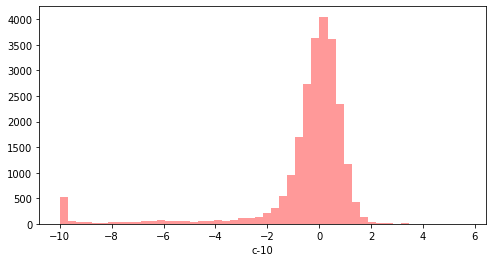

In [ ]:
# distribution of c-10
plt.figure(figsize=(8,4))
sns.distplot(train_x['c-10'], kde=False, color="red")

In [ ]:
train_x[train_x['c-10'] < -8][cell_cols].head()

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,c-10,c-11,c-12,c-13,c-14,c-15,c-16,c-17,c-18,c-19,c-20,c-21,c-22,c-23,c-24,c-25,c-26,c-27,c-28,c-29,c-30,c-31,c-32,c-33,c-34,c-35,c-36,c-37,c-38,c-39,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
16,-10.000,-9.950,-10.000,-10.000,-10.000,-10.000,-10.000,-7.978,-10.000,-9.877,-10.000,-10.000,-10.000,-10.000,-7.967,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-7.206,-10.000,-9.859,-9.859,-9.859,-9.859,-9.859,-9.859,-9.859,-9.8590,-9.859,-9.859,-9.859,-9.859,-6.101,-9.859,-9.859,...,-10.000,-9.5910,-10.000,-10.000,-8.511,-10.000,-10.000,-10.000,-10.0000,-8.887,-10.000,-10.000,-10.000,-10.000,-4.902,-9.984,-5.552,-9.984,-9.9840,-9.984,-9.984,-9.984,-9.984,-9.984,-9.984,-9.984,-9.796,-8.177,-9.8990,-9.984,-9.984,-9.9840,-9.984,-9.984,-9.984,-9.984,-9.984,-9.984,-9.984,-6.784
65,-2.207,-6.688,-3.566,-2.216,-5.629,-3.333,-3.656,-1.977,-3.823,-4.390,-8.707,-3.322,-2.135,-9.745,-2.846,-1.540,-1.041,-2.134,-4.439,-1.094,-3.260,-3.660,-2.675,-1.270,-3.091,-5.586,-9.172,-5.111,-6.441,-2.053,-3.128,-1.695,0.9595,-3.858,-1.745,-1.181,-4.335,-1.738,-7.067,-2.611,...,-2.543,-0.7527,-1.704,-2.759,-7.020,-8.853,-4.367,-2.867,-0.0244,-2.487,-2.358,-5.924,-1.288,-2.615,-1.345,-9.166,-2.815,-5.165,-0.9135,-2.172,-3.131,-4.433,-3.920,-5.505,-6.243,-2.873,-1.117,-3.011,-0.4932,-1.695,-2.376,-0.7508,-2.586,-7.078,-2.757,-0.568,-1.683,-1.759,-6.832,-4.066
76,-9.650,-8.691,-9.348,-6.068,-10.000,-9.758,-10.000,-6.049,-9.807,-6.657,-10.000,-10.000,-9.600,-10.000,-6.969,-7.258,-7.879,-10.000,-10.000,-6.931,-10.000,-8.527,-2.975,-5.371,-7.995,-9.473,-9.709,-9.709,-7.584,-5.846,-7.122,-9.709,-8.7560,-9.709,-9.503,-8.216,-8.525,-3.842,-9.709,-9.709,...,-9.995,-8.7340,-7.370,-9.995,-6.135,-9.986,-8.504,-8.528,-9.9950,-6.254,-9.995,-6.955,-9.995,-9.743,-3.457,-8.712,-3.972,-8.709,-10.0000,-8.461,-9.347,-8.698,-9.807,-10.000,-10.000,-10.000,-5.657,-5.513,-8.2840,-9.490,-8.729,-10.0000,-7.834,-9.538,-10.000,-8.520,-10.000,-7.436,-6.918,-5.235
119,-9.809,-10.000,-10.000,-6.181,-10.000,-10.000,-10.000,-6.915,-10.000,-7.209,-10.000,-10.000,-9.661,-10.000,-7.391,-10.000,-6.552,-10.000,-10.000,-8.033,-10.000,-9.384,-8.618,-8.368,-9.782,-9.917,-9.917,-9.917,-9.917,-5.157,-8.243,-9.917,-9.9170,-9.917,-9.917,-9.498,-9.917,-4.546,-9.917,-9.917,...,-9.978,-9.9780,-9.978,-9.978,-8.823,-9.978,-9.513,-9.832,-9.9780,-6.568,-9.978,-8.664,-9.978,-9.978,-4.073,-10.000,-5.163,-7.797,-10.0000,-8.297,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-8.019,-8.688,-9.6580,-9.308,-10.000,-10.0000,-7.703,-10.000,-10.000,-9.054,-10.000,-8.771,-9.694,-5.548
209,-9.885,-9.262,-9.885,-9.885,-9.885,-8.619,-9.885,-8.210,-9.819,-4.059,-9.885,-9.885,-9.885,-9.885,-8.816,-9.885,-8.255,-9.784,-9.885,-8.123,-9.885,-9.885,-9.281,-8.068,-9.885,-9.980,-9.980,-9.980,-8.973,-9.331,-8.440,-9.980,-9.9800,-9.980,-9.980,-9.095,-9.980,-6.264,-9.980,-9.980,...,-10.000,-9.8570,-10.000,-9.974,-9.062,-9.896,-10.000,-9.553,-10.0000,-7.088,-10.000,-10.000,-10.000,-10.000,-4.432,-10.000,-6.025,-8.882,-10.0000,-8.023,-10.000,-10.000,-10.000,-10.000,-10.000,-10.000,-8.517,-7.589,-10.0000,-10.000,-10.000,-10.0000,-8.451,-10.000,-10.000,-8.695,-10.000,-8.559,-8.025,-6.642
